In [46]:
# Simple Unet Model without Time Embeddings
import torch
import torch.nn as nn
import torchvision.transforms.v2 as tfv2

"""
Still need to add the following:
-Conditional
-Time Stamp

Possible Additions:
-BatchNorm
-Self-Attention
-Different Activation Functions
"""

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=8):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(groups, out_channels)
        self.activation = nn.SiLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x
    

class Downscale(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downscale, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x
    
    
class Upscale(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upscale, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
    
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(nn.Module):
    def __init__(self, out_channels, img_size=64):
        super(UNet, self).__init__()
        # Encoder
        self.layer1 = DoubleConv(3, 64)
        self.down1 = Downscale(64, 128)
        self.down2 = Downscale(128, 256)
        self.down3 = Downscale(256, 512)
        #self.down4 = Downscale(512, 1024)

        # Bottleneck
        #self.bottleneck = DoubleConv(512, 512)
        
        # Decoder
        #self.up1 = Upscale(1024, 512)
        self.up2 = Upscale(512, 256)
        self.up3 = Upscale(256, 128)
        self.up4 = Upscale(128, 64)

        # Output
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, timestep):
        # Encoder
        x1 = self.layer1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.down3(x3)
        #x5 = self.down4(x4)

        # Bottleneck
        #x = self.bottleneck(x4)

        # Decoder
        #x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Output
        x = self.out(x)
        return x

In [47]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="mps"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        # logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

999it [00:15, 65.54it/s] 


torch.Size([8, 3, 64, 64])


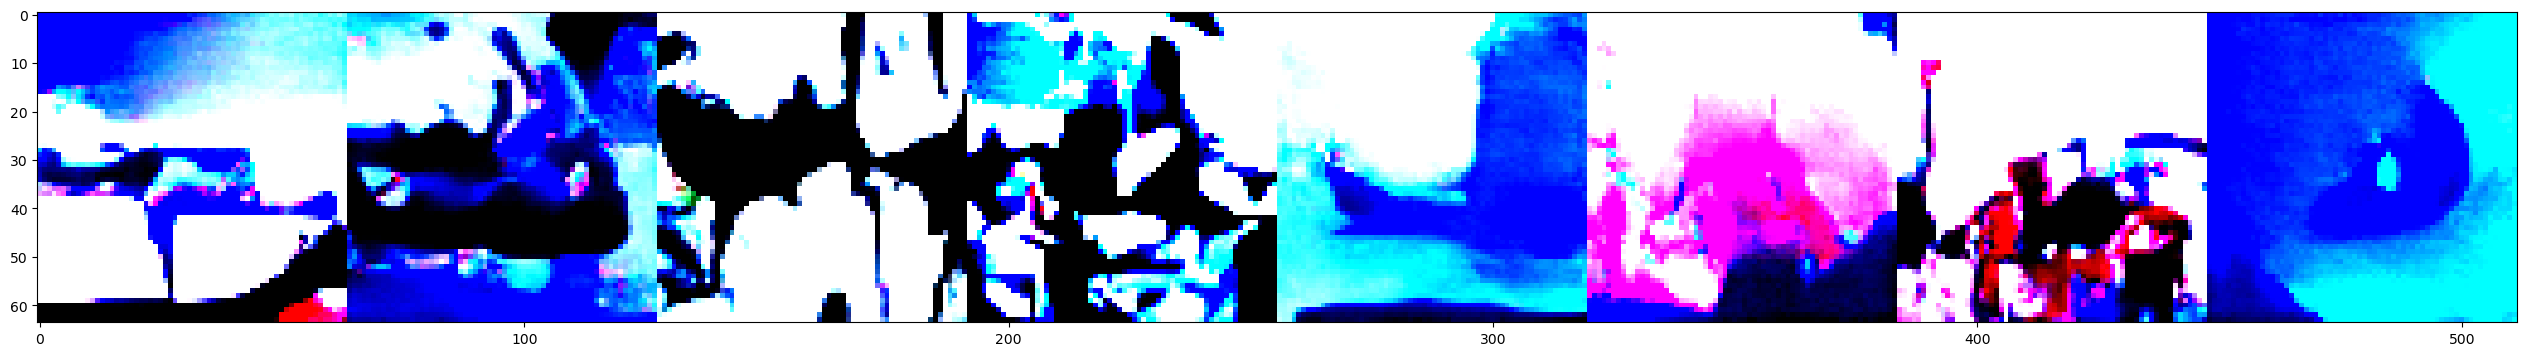

In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/time_model.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

999it [00:12, 79.49it/s]

torch.Size([8, 3, 64, 64])


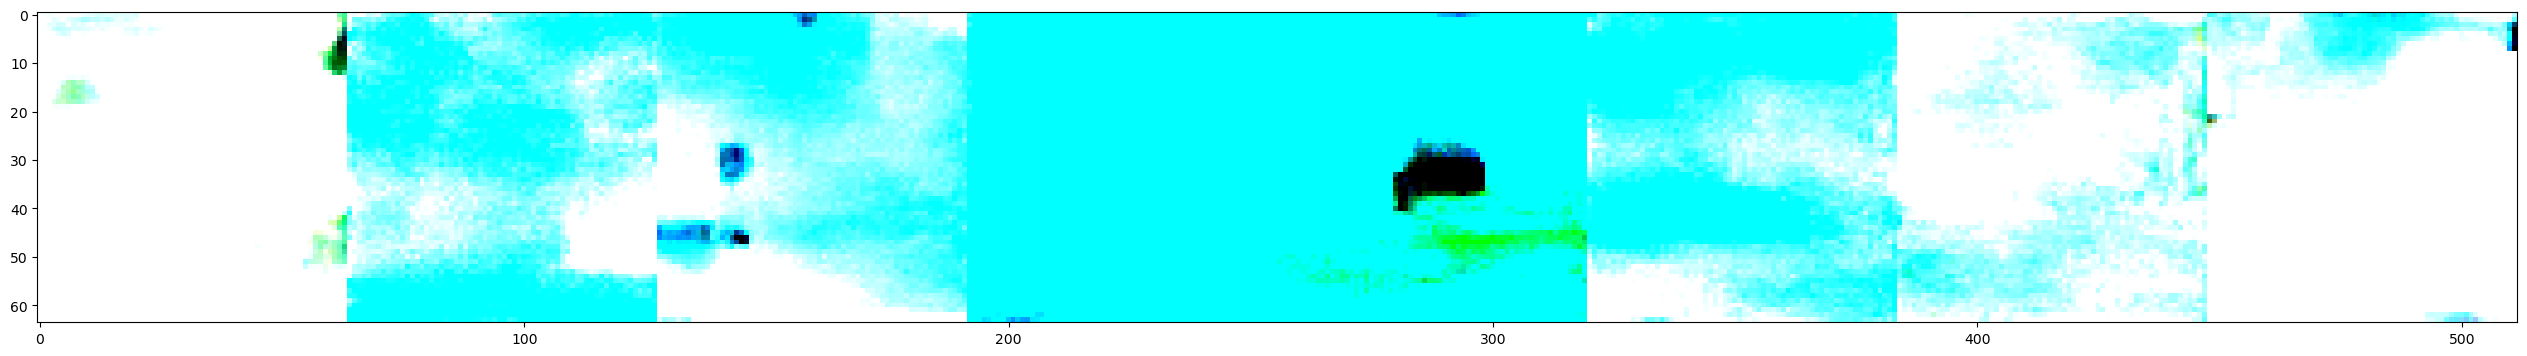

In [7]:
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/no_time_model.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

999it [00:13, 72.95it/s]


torch.Size([8, 3, 64, 64])


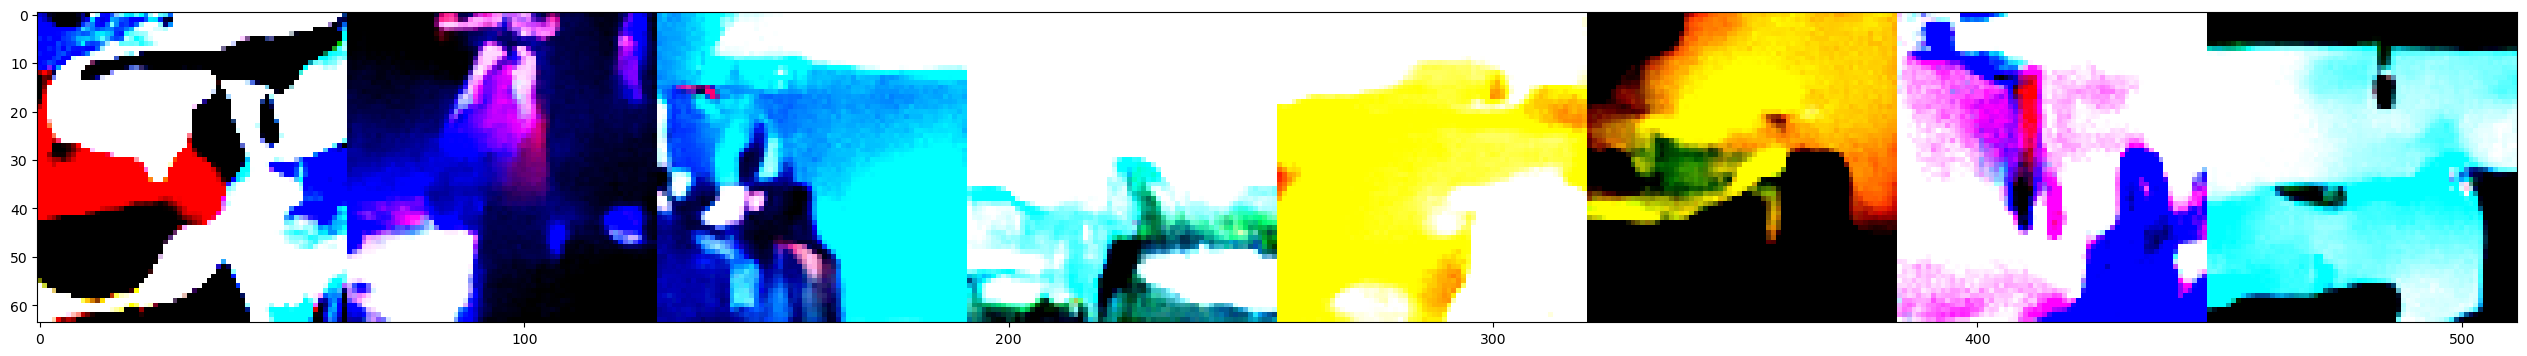

In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 100 Epochs
device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/no_time_model500.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

999it [00:11, 85.17it/s]


torch.Size([8, 3, 64, 64])


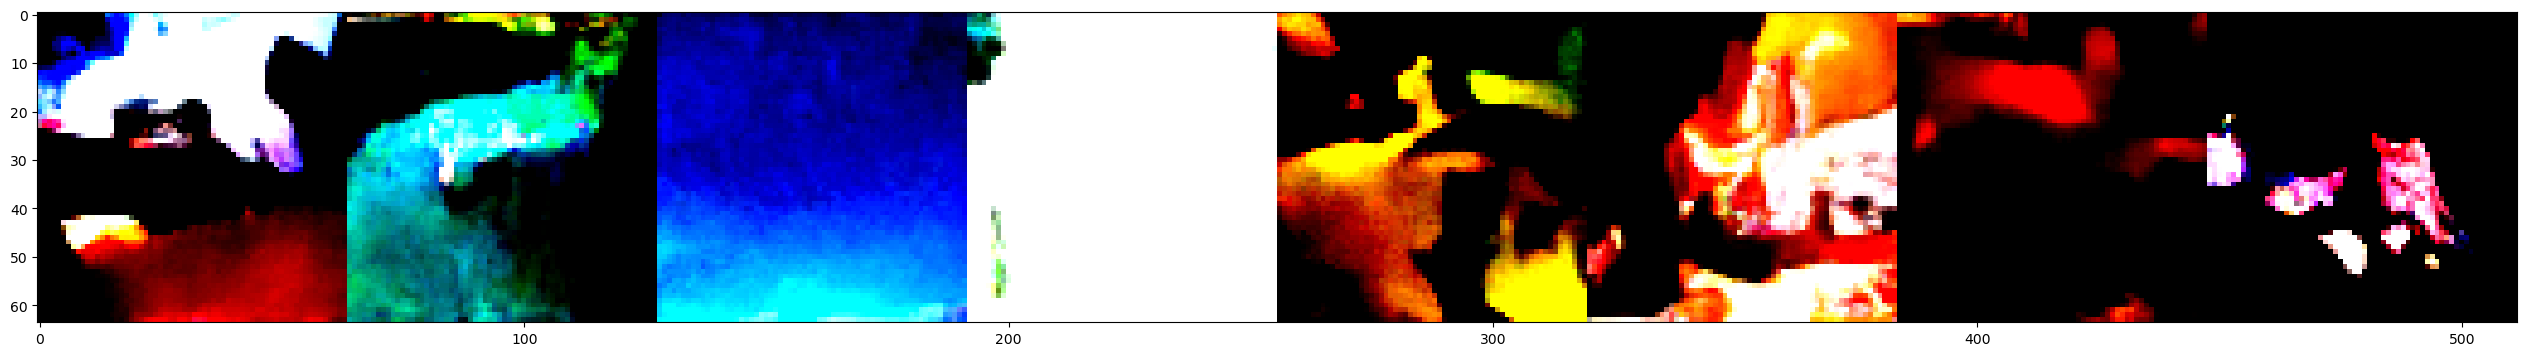

In [30]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 180 epochs
device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/no_time_model500.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

999it [00:13, 75.22it/s]


torch.Size([8, 3, 64, 64])


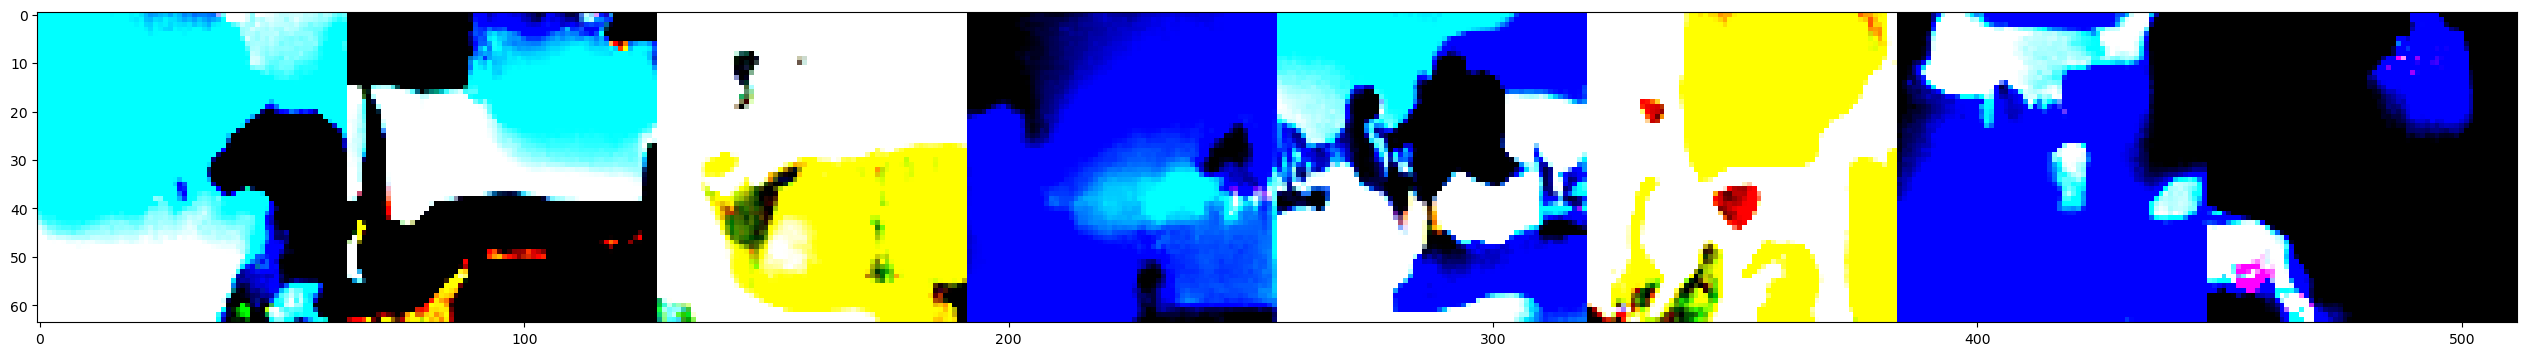

In [31]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 250 epochs
device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/no_time_model500.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

999it [00:13, 74.29it/s]


torch.Size([8, 3, 64, 64])


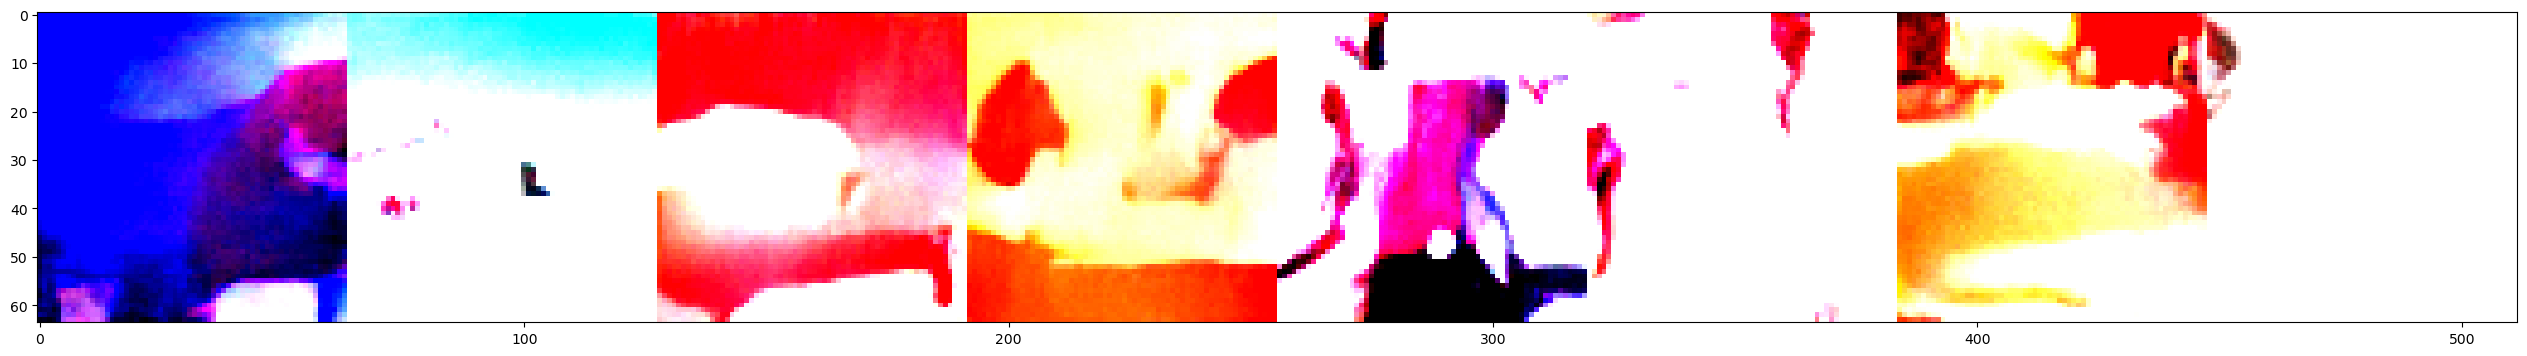

In [32]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 300 epochs
device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/no_time_model500.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

999it [00:13, 74.00it/s]


torch.Size([8, 3, 64, 64])


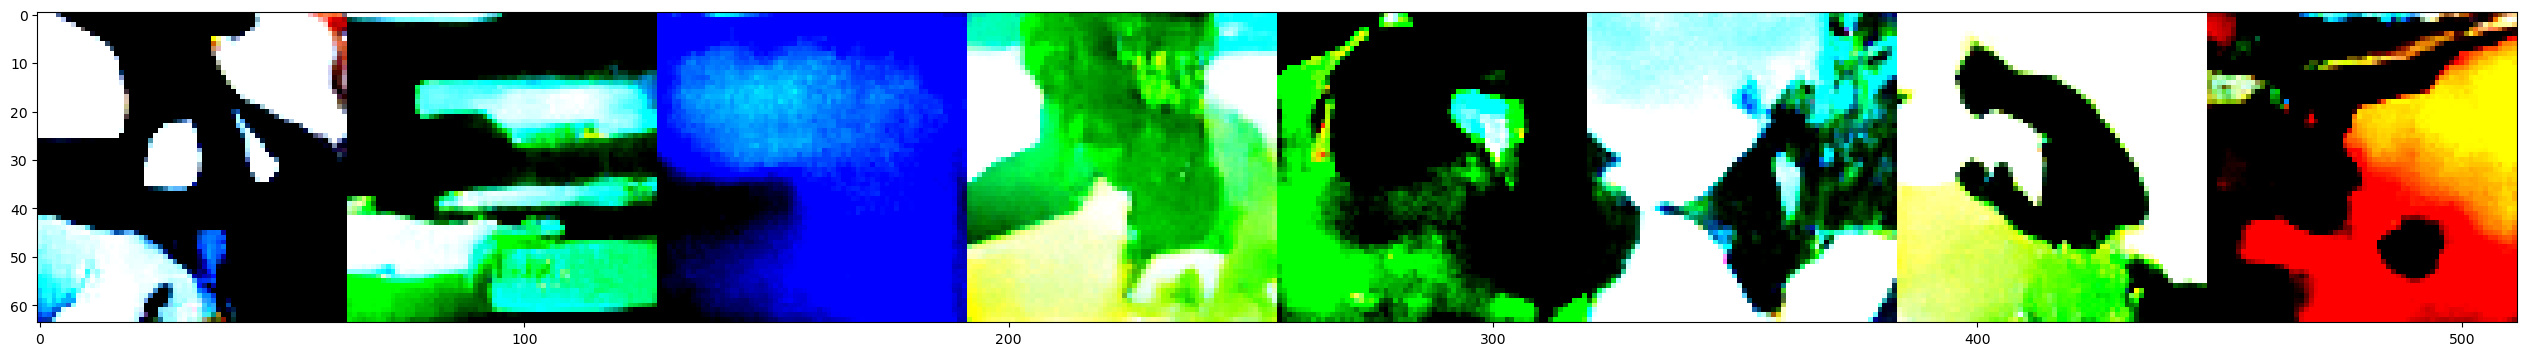

In [33]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 350 epochs
device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/no_time_model500.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

999it [00:13, 72.30it/s]


torch.Size([8, 3, 64, 64])


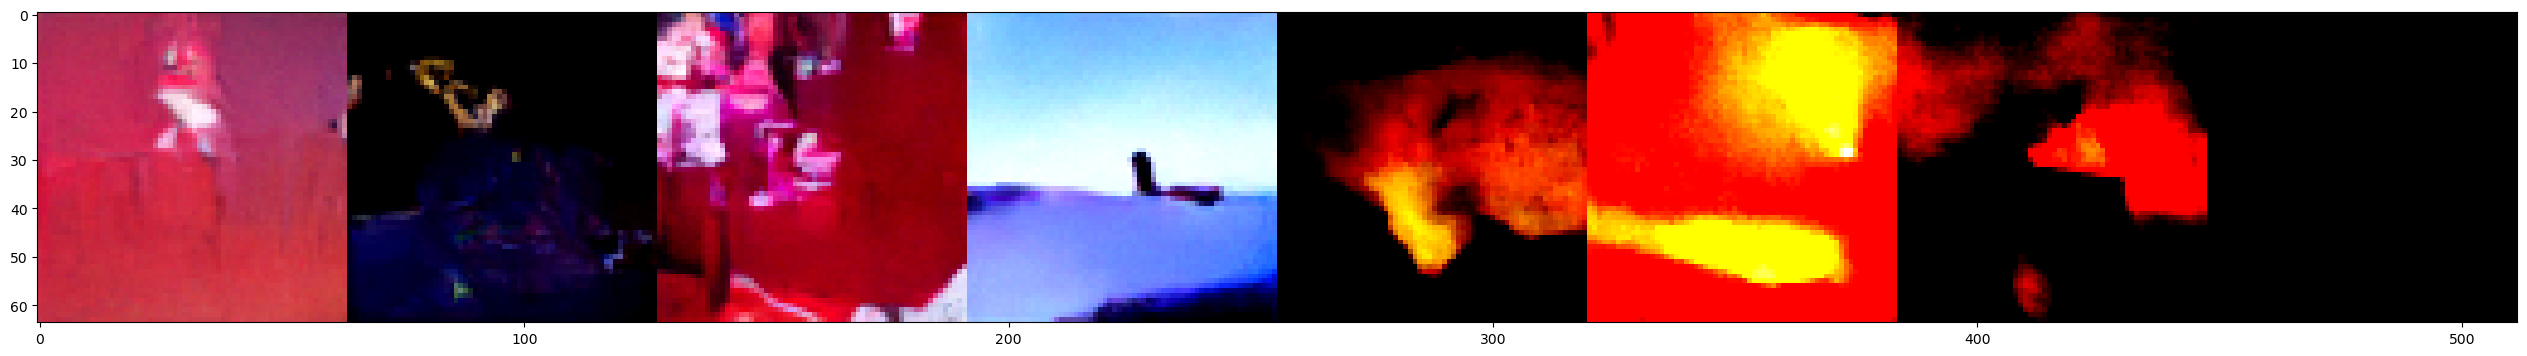

In [35]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 385 epochs
device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/no_time_model500.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

999it [00:08, 119.31it/s]


torch.Size([8, 3, 64, 64])


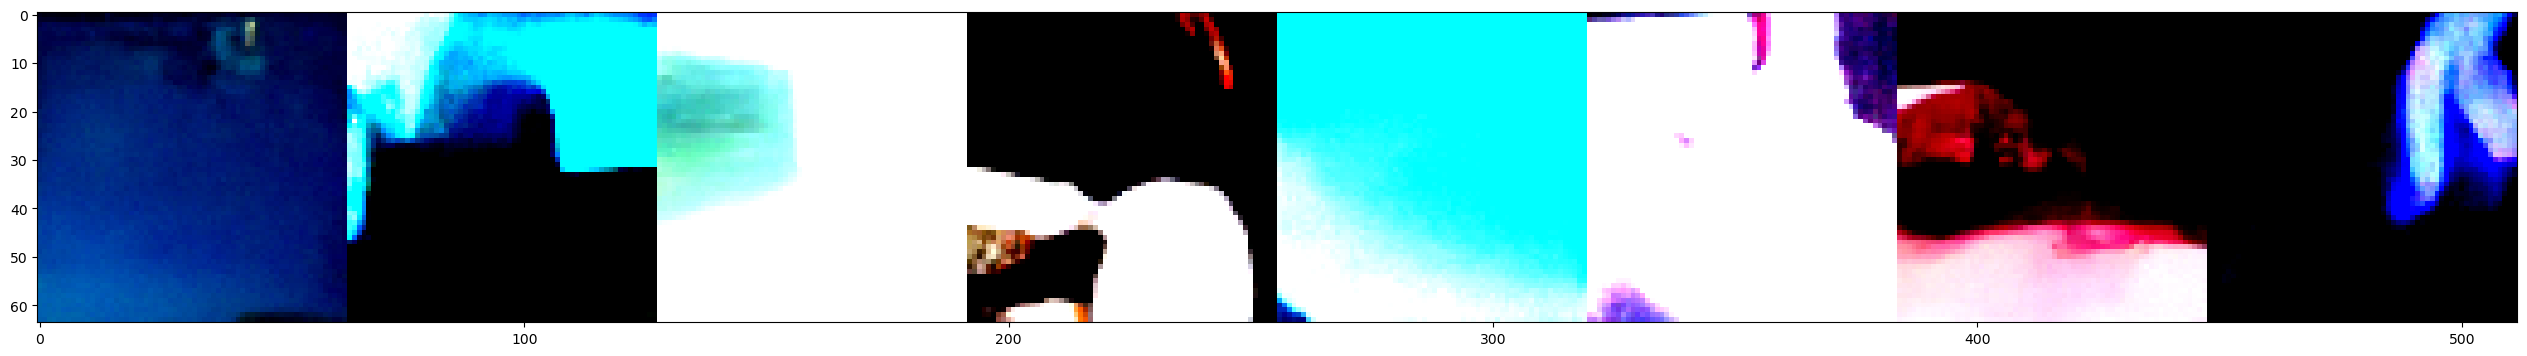

In [37]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 500 epochs
device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/no_time_model500.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

999it [00:13, 74.49it/s]

torch.Size([8, 3, 64, 64])


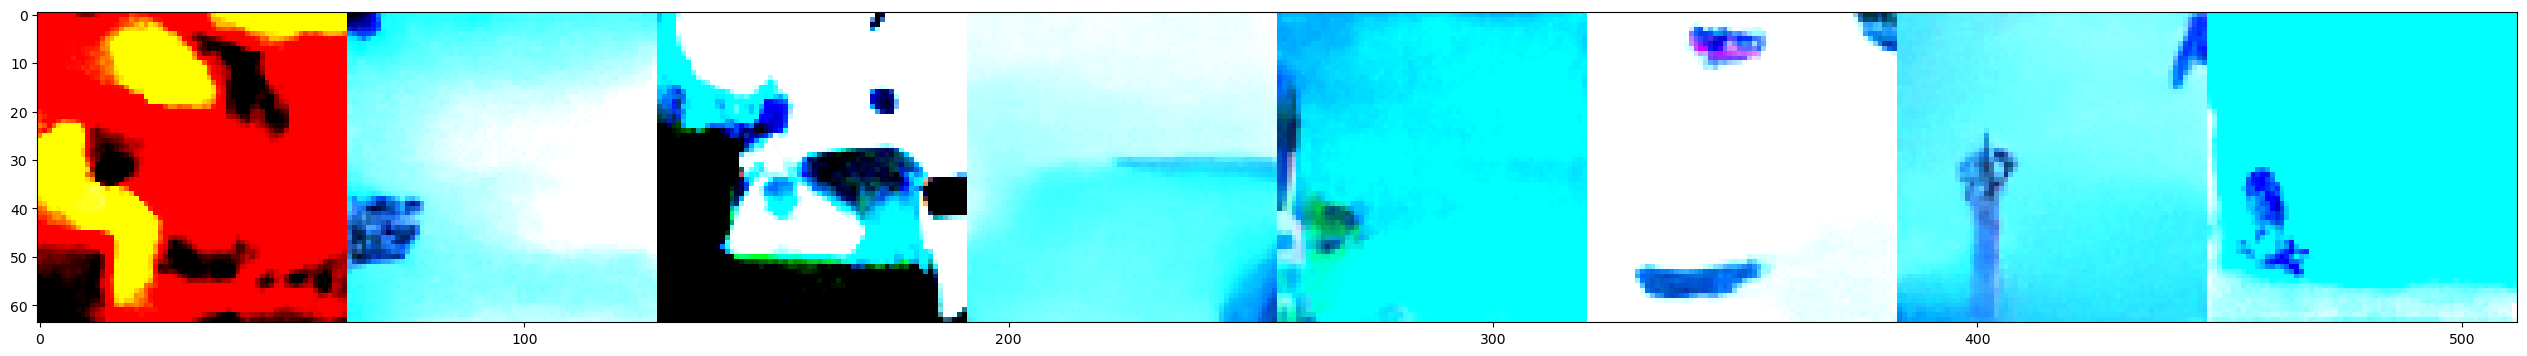

In [45]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 550 epochs
device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/no_time_model650.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

999it [00:13, 72.19it/s]

torch.Size([8, 3, 64, 64])


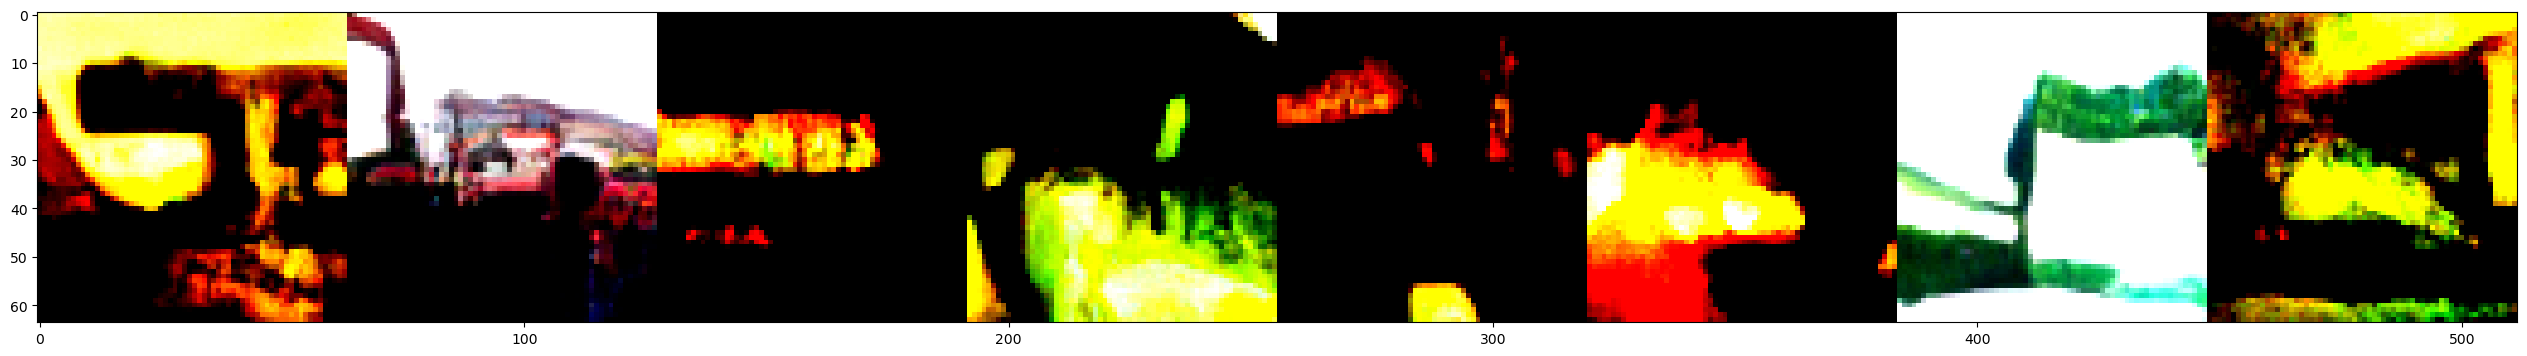

In [50]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 600 epochs
device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/no_time_model650.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 650 epochs
device = "mps"
model = UNet(out_channels=3).to(device)
ckpt = torch.load("models/no_time_model650.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
x = diffusion.sample(model, 8)
print(x.shape)
plt.figure(figsize=(32, 32))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()